In [97]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import pandas as pd
import numpy as np
from accrual import process_crsp, process_compustat, merge_data, backtest

In [20]:
data = process_crsp('data/crsp_monthly2.gz')

Total rows: 4335433
1950-01-31 00:00:00 to 2018-12-31 00:00:00
Remove all NAs: 4304938 (99.30%)
Remove Zs: 4302309 (99.24%)
Remove financials: 3168271 (73.08%)
Remove delisted rows: 3081542 (71.08%)
Remove duplicated rows: 3065321 (70.70%)
Duplicated for key [PERMNO, date]: 0
PERMNO year: 276015


In [33]:
funda = process_compustat('data/compustat_annual.gz')

Total rows: 302087
Drop NAs: 232651 (77.01%)
Duplicated PERMNO fyear: 2
Drop duplicates: 232649 (77.01%)
Duplicated PERMNO fyear: 0
Zero total asset: 23
Drop zero AT: 232626 (77.01%)
Merged with previous fyear: 220785 (73.09%)
Final rows: 220409 (72.96%)


In [36]:
merged = merge_data(data.reset_index(), funda)

Total rows: 276015
Valid PERMNO: 254461 (92.19%)
Merged: 254461 (92.19%)
Filled: 254461 (92.19%)
Drop NAs: 211696 (76.70%)


In [84]:
aaa.index.values

array([ 1553,  1665,  3111,  3828,  4346,  4470,  4528,  5595,  6777,
        7136,  7757,  7875,  9713, 11188, 12449, 12926, 15248, 16150,
       17762, 18298, 18359, 18711, 20105, 20703, 20852, 21267, 22247,
       22761, 23885, 24360, 24432, 24830, 27028, 27169, 27273, 30128,
       30321, 31083, 31373, 31514, 31927, 31991, 32278, 34238, 34401,
       35126, 35198, 35519, 35615, 36191, 37518, 37582, 37789, 37874,
       38044, 38106, 38353, 38475, 39304, 39696, 40022, 40989, 41127,
       41335, 41617, 41818, 42213, 42354, 42572, 42918, 43056, 43403,
       43541, 43783, 44030, 44119, 44294, 44617, 44735, 44775, 44876,
       45021, 45064, 45287, 45525, 45565, 45611, 45661, 45884, 45965,
       46562, 46686, 46791, 47026, 47128, 47377, 47457, 47598, 47749,
       48163, 48982, 49175, 49531, 49568, 49800, 49839, 50181, 50348,
       50799, 50901, 51246, 51553, 51630, 51699, 51770, 51842, 51949,
       52022, 52091, 52216, 52529, 52588, 52691, 52753, 53514, 53786,
       54374, 54544,

In [99]:
equity = backtest(merged)

In [262]:
np.power(12, 1/69)

1.0366694680848143

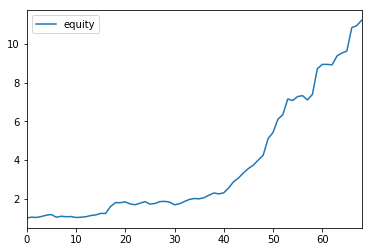

In [100]:
pd.DataFrame({'equity': (np.array(equity) + 1).cumprod()}).plot()

In [143]:
raw = pd.read_feather('data/new_crsp')
raw.columns

Index(['permno', 'permco', 'ncusip', 'date', 'shrcd', 'exchcd', 'siccd', 'ret',
       'vol', 'shrout', 'prc', 'cfacpr', 'cfacshr', 'join_date', 'price'],
      dtype='object')

In [149]:
(data.siccd == 'Z').sum()

0

In [153]:
raw = pd.read_feather('data/new_crsp')

columns_kept = ['date', 'permco', 'permno', 'siccd', 'ret']
tota_rows = raw.shape[0]
print(f'Total rows: {tota_rows}')
print(f'{raw.date.min()} to {raw.date.max()}')

data = data[(data.siccd < 6000) | (data.siccd >= 7000)]  # remove financial
print(f'Remove financials: {data.shape[0]} ({data.shape[0] / tota_rows:.2%})')

dup = data[['permno', 'date']].duplicated().sum()
print(f'Duplicated for key [PERMNO, date]: {dup}')

Total rows: 3017885
1970-01-30 00:00:00 to 2018-12-31 00:00:00
Remove financials: 2475632 (82.03%)
Duplicated for key [PERMNO, date]: 0


In [154]:
funda = process_compustat('data/compustat_annual.gz')

Total rows: 302087
1950-06-30 00:00:00 to 2018-12-31 00:00:00
Drop NAs: 232651 (77.01%)
Duplicated PERMNO fyear: 2
Drop duplicates: 232649 (77.01%)
Duplicated PERMNO fyear: 0
Zero total asset: 23
Drop zero AT: 232626 (77.01%)
Merged with previous fyear: 220785 (73.09%)
Final rows: 220409 (72.96%)


In [174]:
from pandas.tseries.offsets import MonthEnd

In [161]:
funda.rename(lambda x: x.lower(), axis=1, inplace=True)

In [175]:
data['next_ret'] = data.groupby('permno', as_index=False).ret.shift(-1)
data['join_date'] = data.date + MonthEnd(0)

In [184]:
funda1 = funda.loc[:, ['date', 'permno', 'year', 'dwc', 'dnco', 'dfin', 'tacc']]
funda1['join_date'] = funda.date + MonthEnd(0)
funda1.permno = funda1.permno.astype('int')

In [209]:
index = ['join_date', 'permno']
joined = pd.merge(data, funda1.drop(['date', 'year'], axis=1), on=index, how='left')
joined = joined.groupby('permno', as_index=False).fillna(method='ffill')

In [210]:
print(data.shape[0])
print(joined.shape[0])

2475632
2475632


In [298]:
final = joined.dropna(subset=['dwc', 'dnco', 'dfin', 'tacc']).copy()
print(final.shape[0])

2129965


In [299]:
for col in ['dwc', 'dnco', 'dfin', 'tacc']:
    final['r' + col[1:]] = final.groupby('join_date', as_index=False)[col].transform(lambda x: pd.qcut(x, 10, range(10)))

In [303]:
rets = final.groupby(['join_date', 'rwc'], as_index=False).next_ret.mean() \
            .pivot(index='join_date', columns='rwc', values='next_ret')

In [304]:
rets['longshort'] = rets[0] - rets[9]
rets['cum'] = (1 + rets.longshort).cumprod()

In [305]:
rets.tail()

rwc,0,1,2,3,4,5,6,7,8,9,longshort,cum
join_date,,,,,,,,,,,,
2018-08-31,-0.011649,-0.022242,-0.009836,0.001309,-0.003686,-0.020029,-0.011949,-0.016887,-0.037613,-0.015346,0.003697,21.175207
2018-09-30,-0.125198,-0.108234,-0.108175,-0.103784,-0.083066,-0.093558,-0.103989,-0.105563,-0.114226,-0.114264,-0.010934,20.943675
2018-10-31,-0.031853,-0.010197,-0.004096,0.000901,-0.002213,0.003640,-0.005023,0.001573,0.006829,-0.018000,-0.013853,20.653544
2018-11-30,-0.147373,-0.146765,-0.120882,-0.124657,-0.116595,-0.123654,-0.139716,-0.135871,-0.136471,-0.172779,0.025406,21.178261
2018-12-31,-0.160538,-0.148031,-0.128721,-0.121380,-0.124196,-0.123850,-0.129022,-0.137297,-0.141604,-0.152616,-0.007922,21.010478


In [254]:
np.power(21, 1/49)

1.0641039792183271

In [252]:
rets.shape[0] / 12

49.0

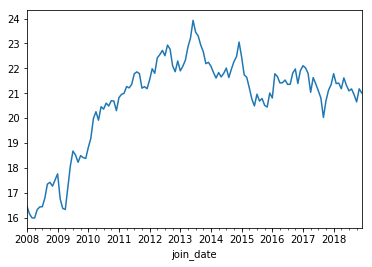

In [269]:
rets.loc['2008-01-01':].cum.plot()